# CryoEM Example - Synthetic and EMPIAR

### Context

Electron Microscopy aims to image particles (e.g., proteins, molecules) on a near atomic resolution. However, with great resolution comes low signal-to-noise ratio. As such, computer vision models need to be trained on noisy datasets in order to detect objects.

The structure of the objects being imaged is calculated by averaging hundreds if not thousands of frames of said object in different orientations, rotations and positions. The dataset generated is, consequently, large - usually, the pre-processed images (or with some degree of processing like motion correction) are uploaded onto an online database called EMPIAR.

In this notebook, we use scivision to load memory-friendly synthetic data (AlphabetSoup with a noise filter) and real data from the online database of EM images (EMPIAR), and run them through our pre-trained Object Detection in Images with Noise (odin) model.

## Import and configure packages

In [1]:
import matplotlib.pyplot as plt
import scivision

from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

In [2]:
# matplotlib settings
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams["image.cmap"] = "gray"

## Load the pretrained ODIN model

The model for the object detection in noisy images is build with a FastRCNN, and pre-trained on the synthetic dataset. With Scivision, we can load this pretrained model simply with one line:

In [20]:
model = scivision.load_pretrained_model(
    "https://github.com/alan-turing-institute/odin", 
    allow_install=True, 
    branch="main",
)

Model loaded from /home/quantumjot/Downloads/checkpoint.pt


## Synthetic data example

The repository containing this notebook itself provides a **Scivision datasource**, describing some synthetic data, which we use in the first example.

Load the datasource contained in this directory:

In [4]:
cat = scivision.load_dataset("./")

Inspecting its contents, we notice that there are two entries: For this first example, we will use `synthetic_soup`:

In [5]:
list(cat.keys())

['synthetic_soup', 'one_empiar_dataset']

In [6]:
cat.synthetic_soup.description

'Generate numpy array of synthetic cryoEM images'

In [21]:
images, bounding_boxes, labels = cat.synthetic_soup.read()

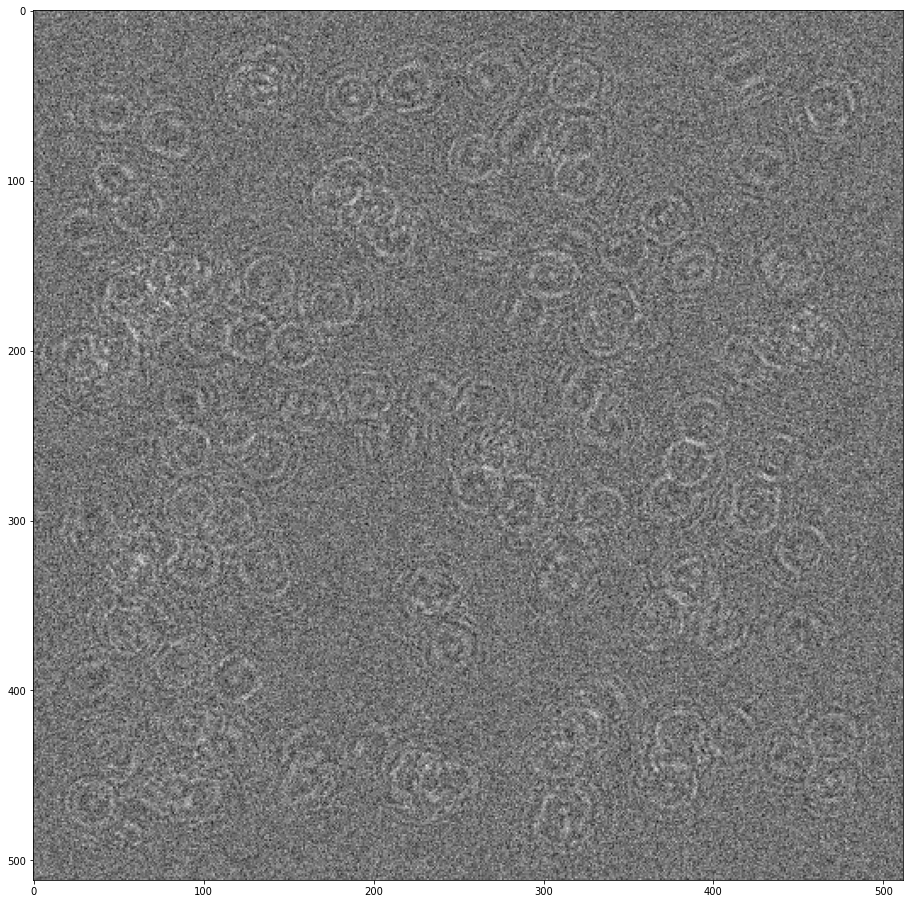

In [8]:
plt.imshow(images[0])

Use the trained ODIN model to make predictions about particle locations:

In [19]:
bounding_boxes_model_prediction = model.predict(images[0])

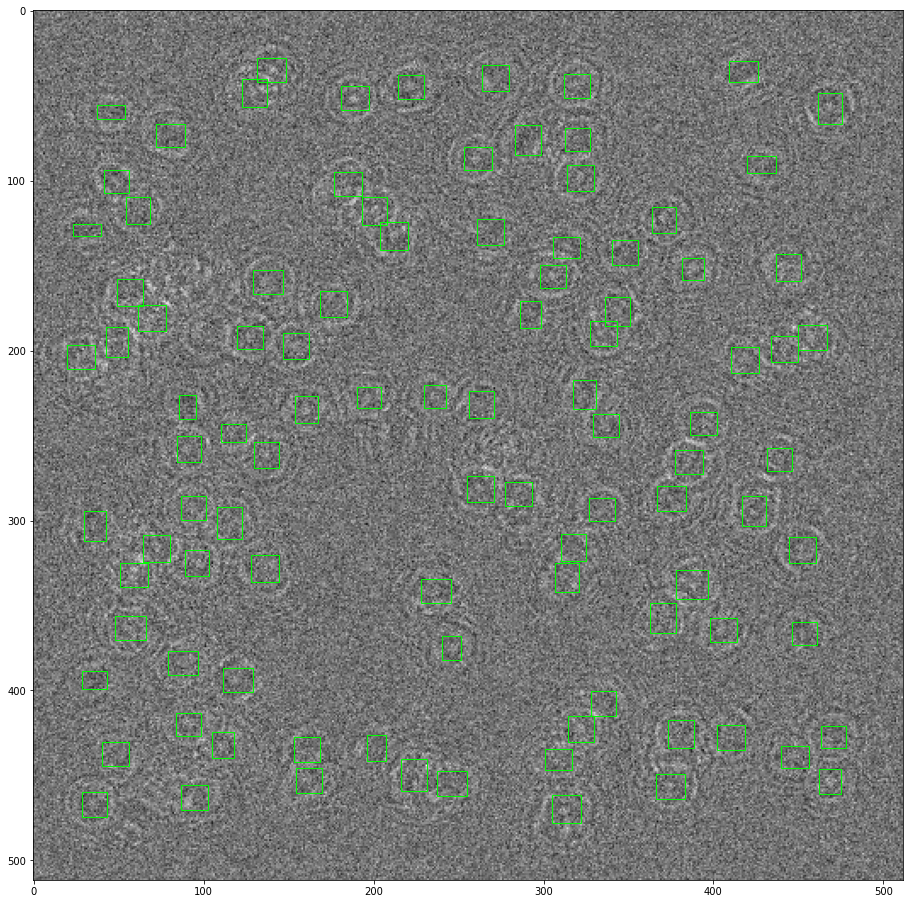

In [18]:
def box_to_patch(xmin, ymin, xmax, ymax, color=(0,1,0)):
    return Rectangle(
        xy=(xmin, ymin),
        height=ymax - ymin,
        width=xmax - xmin,
        linewidth=1,
        edgecolor=color,
        facecolor='none',
    )


plt.imshow(images[0])

ax = plt.gca()
for bbox in bounding_boxes_model_prediction:
    ax.add_patch(box_to_patch(*bbox))

# for bbox in bounding_boxes[0]:
#     ax.add_patch(box_to_patch(*bbox, color=(1, 0, 1)))

## EMPIAR example

We now look at the second entry in the catalog, `one_empiar_dataset`, which points to an entry in the [EMPIAR](https://www.ebi.ac.uk/empiar/) archive.

In this example, we load the entry 10050, which has the micrographs (i.e., the EM-acquired images) of the small protein complex Prx3.

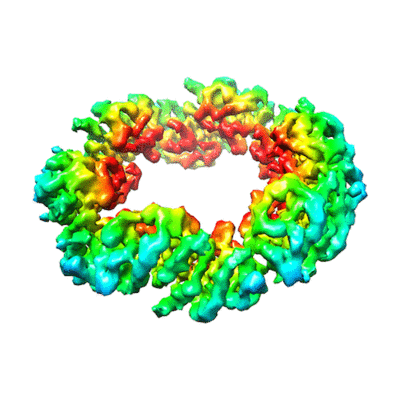
**Figure 1.** Structure of the protein complex Prx3 obtained after averaging the raw data present in the EMPIAR 10050 entry.

This entry turn contains several sets of images, one of which we load:

In [11]:
keys = list(cat.one_empiar_dataset.keys())
keys

['VPP_Prx3_4.4res', 'VPP_Prx3_7.3res', 'No_VPP_mrc_files', 'No_VPP_dat_files']

In [12]:
empiar_10050 = cat.one_empiar_dataset["VPP_Prx3_7.3res"]
empiar_10050

VPP_Prx3_7.3res:
  args:
    directory: data/VPP_Prx3_7.3res
    empiar_index: 10050
    imageset_metadata:
      category: micrographs - multiframe
      data_format: MRC
      details: ''
      directory: data/VPP_Prx3_7.3res
      frame_range_max: 10
      frame_range_min: 1
      frames_per_image: 10
      header_format: MRC
      image_height: '3710'
      image_width: '3838'
      micrographs_file_pattern: null
      name: VPP_Prx3_7.3res
      num_images_or_tilt_series: 81
      picked_particles_directory: null
      picked_particles_file_pattern: null
      pixel_height: 1.35
      pixel_width: 1.35
      segmentations: []
      voxel_type: SIGNED 16 BIT INTEGER
  description: ''
  driver: intake_cryoem.empiar.EmpiarSource
  metadata:
    catalog_dir: ''


For our example, we want to load just one image from the dataset.  This is done with [`read_partition()`](https://intake.readthedocs.io/en/latest/roadmap.html?highlight=read_partition#reader-api).

In [13]:
image = empiar_10050.read_partition(0)

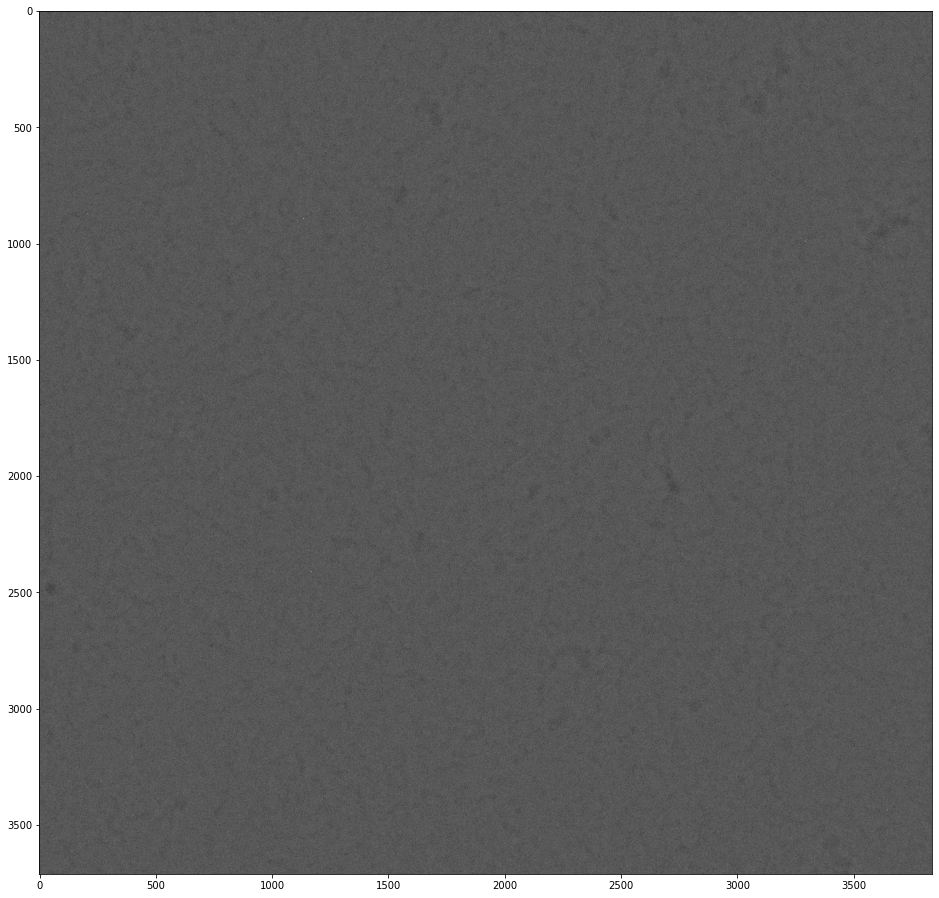

In [14]:
plt.imshow(image.sel(frame=2), norm=LogNorm())

In [15]:
bounding_boxes_empiar_pred = model.predict(image[0, :512, :512])